# Tensorflow project (CNN Classifier)

https://www.tensorflow.org/tutorials/images/cnn

http://cs231n.github.io/

Trained model should be able to classify input images to one of 43 classes (for testing purposes 10 classes might be enough).

## [Data](https://sid.erda.dk/public/)

- [Train dataset](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip)
- [Test dataset](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip)
- [Test data csv with assigned classification](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip)

## Image format

- The images contain one traffic sign each
- Images contain a border of 10 % around the actual traffic sign (at least 5 pixels) to allow for edge-based approaches
- Images are stored in PPM format (Portable Pixmap, P6)
- Image sizes vary between 15x15 to 250x250 pixels
- Images are not necessarily squared
- The actual traffic sign is not necessarily centered within the image.This is true for images that were close to the image border in the full camera image
- The bounding box of the traffic sign is part of the annotatinos (see below)

## Annotation format

Annotations are provided in CSV files. Fields are separated by “;” (semicolon). Annotations contain the following information:

- Filename: Filename of corresponding image
- Width: Width of the image
- Height: Height of the image
- ROI.x1: X-coordinate of top-left corner of traffic sign bounding box
- ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box
- ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box
- ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box



In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image

%matplotlib inline
tf.__version__

2024-04-05 08:54:23.067305: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 08:54:23.069851: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 08:54:23.106793: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 08:54:23.753302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.16.1'

## Loading & prepare training images

In [2]:
data_range = range(10)
image_final_size = (64, 64)
training_data_path = "./GTSRB/Final_Training/Images/"

csv_data = []
X_train = []
y_train = []

for i in data_range:
    number = '{:05d}'.format(i)
    data_path = os.path.join(training_data_path, number)
    raw_csv=pd.read_csv(os.path.join(data_path, "GT-"+number+".csv"), delimiter=";")
    csv_data.append(raw_csv)

    raw_csv["Filename"].apply(lambda x: X_train.append(Image.open(os.path.join(data_path, x))))
    raw_csv["ClassId"].apply(lambda y: y_train.append(y))

images_df = pd.concat(csv_data, ignore_index=True)

for i in range(len(images_df)):
    image_data = images_df.loc[i]
    x1, y1, x2, y2 = image_data["Roi.X1"], image_data["Roi.Y1"], image_data["Roi.X2"], image_data["Roi.Y2"]
    X_train[i] = np.asarray(X_train[i].crop((x1, y1, x2, y2)).resize(image_final_size))

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_train = X_train / 255.0


## Loading & prepare test images

In [3]:
training_data_path = "./GTSRB/Final_Test/Images/"

X_test = []
y_test = []

images_df = pd.read_csv("./GTSRB/GT-final_test.csv", delimiter=";")

for i in range(len(images_df)):
    image_data = images_df.loc[i]
    if image_data["ClassId"] not in data_range:
        continue
    
    x1, y1, x2, y2 = image_data["Roi.X1"], image_data["Roi.Y1"], image_data["Roi.X2"], image_data["Roi.Y2"]
    image = Image.open(os.path.join(training_data_path, image_data["Filename"]))
    X_test.append(np.asarray(image.crop((x1, y1, x2, y2)).resize(image_final_size)))
    y_test.append(image_data["ClassId"])

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

X_test = X_test / 255.0


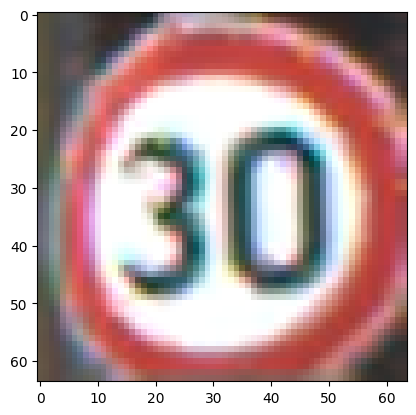

In [4]:
plt.imshow(X_test[0])

## Defining the model

In [5]:
model = models.Sequential()
model.add(layers.InputLayer((image_final_size[0], image_final_size[1], 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding="same"))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(units=len(data_range), activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,018 (316.48 KB)

 Trainable params: 81,018 (316.48 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling and training the model

In [6]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["sparse_categorical_accuracy"])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5


2024-04-05 08:54:30.212420: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 721059840 exceeds 10% of free system memory.


459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 1.7496 - sparse_categorical_accuracy: 0.3502 - val_loss: 0.4622 - val_sparse_categorical_accuracy: 0.8783
Epoch 2/5
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.2430 - sparse_categorical_accuracy: 0.9295 - val_loss: 0.3363 - val_sparse_categorical_accuracy: 0.9060
Epoch 3/5
459/459 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.1216 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.3591 - val_sparse_categorical_accuracy: 0.8981
Epoch 4/5
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0794 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.2656 - val_sparse_categorical_accuracy: 0.9285
Epoch 5/5
459/459 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.3262 - val_sparse_categorical_accuracy: 0.9385


## Evaluate the model

150/150 - 1s - 6ms/step - loss: 0.3262 - sparse_categorical_accuracy: 0.9385
Final accuracy: 0.9385%


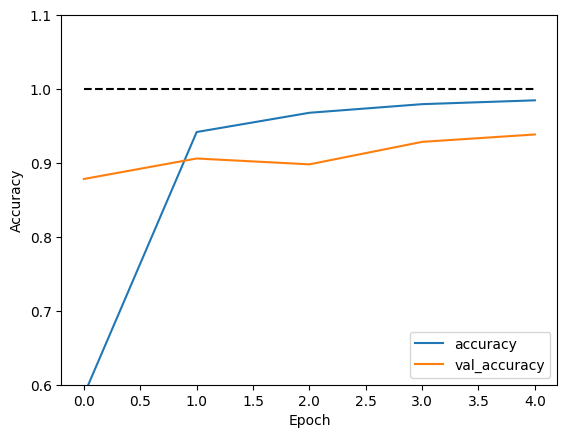

In [7]:
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.plot([0, 4], [1,1], "k--")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print(f"Final accuracy: {round(test_acc, 4)}%")
